In [1]:
import re
import numpy as np
import pandas as pd

In [2]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
#spacy for lemmatization
import spacy


In [4]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Remove deprecationWarning that I can't fix
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from pprint import pprint

In [6]:
# NLTK for removing stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tagum', 'city', 'davao','ordinance', 'thereof', 'section', 'municipal', 'municipality', 'government'])

In [7]:
# Import CSV Ordinance Dataset
df = pd.read_csv('ordinances/tagum_ordinances.csv', header = 0)
print(df)
df.head()

                                     OR  \
0        CITY ORDINANCE No. 842, s-2018   
1        CITY ORDINANCE NO. 825, s-2017   
2        CITY ORDINANCE NO. 837, s-2018   
3        CITY ORDINANCE NO. 844, s-2018   
4        CITY ORDINANCE NO. 838, s-2018   
..                                  ...   
670  MUNICIPAL ORDINANCE NO. 05, s-1974   
671  MUNICIPAL ORDINANCE NO. 04, s-1974   
672  MUNICIPAL ORDINANCE NO. 01, s-1974   
673    MUNICIPAL ORDINANCE NO. 03, 1973   
674  MUNICIPAL ORDINANCE NO. 02, S-1973   

                                                    OT  
0    “AN ORDINANCE REGULATING THE PRACTICE OF TRADI...  
1    “AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...  
2    “AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...  
3    AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE...  
4    “AN ORDINANCE CREATING THE CITY HISTORICAL, CU...  
..                                                 ...  
670  “AN ORDINANCE AMENDING SECTION 10 OF MUNICIPAL...  
671  “AN ORDINANCE REGULATI

,OR,OT
0,"CITY ORDINANCE No. 842, s-2018",“AN ORDINANCE REGULATING THE PRACTICE OF TRADI...
1,"CITY ORDINANCE NO. 825, s-2017",“AN ORDINANCE RECONSTITUTING THE MEMBERS OF TH...
2,"CITY ORDINANCE NO. 837, s-2018",“AN ORDINANCE ESTABLISHING FUNERAL AND BURIAL ...
3,"CITY ORDINANCE NO. 844, s-2018","AN ORDINANCE AMENDING THE TITLE, SECTION 1, SE..."
4,"CITY ORDINANCE NO. 838, s-2018","“AN ORDINANCE CREATING THE CITY HISTORICAL, CU..."


In [8]:
# List all ordinance titles
# Convert to list
data = list(df.OT) 
print(data[:1])

['“AN ORDINANCE REGULATING THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.']


In [9]:
# Remove qoutes
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub("\"", "", sent) for sent in data]

# Remove words ending with ING like amending, regulating
# Implemtation to be improved / Seems to improve topics
data = [re.sub('\S*ING\S*\s?', '', sent) for sent in data]


pprint(data[:5])

['“AN ORDINANCE THE PRACTICE OF TRADITIONAL HOME BIRTH DELIVERY OR DELIVERIES '
 'ATTENDED BY A TRADITIONAL BIRTH ATTENDANT OR MANANABANG”.',
 '“AN ORDINANCE THE MEMBERS OF THE CITY TRICYCLE AND REGULATORY BOARD (CTFRB) '
 'ITS FUNCTIONS AND PROCEDURES AND MOTORIZED TRICYCLE FOR HIRE (MTH), TRICYCLE '
 'UTILITY VEHICLE (TUV) AND TRICYCLE UTILITY FOR HIRE (TUH) GUIDELINES, '
 'REGULATIONS AND OPERATIONS, THE COLLECTION OF FEES, CHARGES,ADMINISTRATIVE '
 'PROVISIONS AND PENALTIES FOR VIOLATION THEREOF”.',
 '“AN ORDINANCE FUNERAL AND BURIAL ASSISTANCE FOR INDIGENT TAGUMENYOS, ITS '
 'MANAGEMENT, PROCEDURES AND GUIDELINES AND FUNDS THEREFOR”.',
 'AN ORDINANCE THE TITLE, SECTION 1, SECTION 2 AND SECTION 3 OF CITY ORDINANCE '
 'NO. 820, S-2017 “AN ORDINANCE INTO A LOAN AGREEMENT WITH THE DEVELOPMENT '
 'BANK OF THE PHILIPPINES, IN THE AMOUNT OF SIX HUNDRED EIGHTY MILLION PESOS '
 '(P 680,000,000.00) TO FUND THE ACQUISITION OF HEAVY EQUIPMENT,ACQUISITION OF '
 'SERVICE VEHICLES, ACQUISITION O

In [10]:
#preprocess using gensim simple_preprocess and tokenize into words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['an',
  'ordinance',
  'the',
  'practice',
  'of',
  'traditional',
  'home',
  'birth',
  'delivery',
  'or',
  'deliveries',
  'attended',
  'by',
  'traditional',
  'birth',
  'attendant',
  'or',
  'mananabang']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:

# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['an',
 'ordinance',
 'the',
 'practice',
 'of',
 'traditional',
 'home',
 'birth',
 'delivery',
 'or',
 'deliveries',
 'attended',
 'by',
 'traditional',
 'birth',
 'attendant',
 'or',
 'mananabang']


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Code snippets from Selva Prabhakaran | Topic Modeling with Gensim (Python)
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stemmer(texts):
    new_list = []
    temp = []
    for lists in texts:
        new_list.append(temp)
        for word in lists:
            temp.append(ps.stem(word))
        temp = []
    return new_list

In [14]:
# Remove Stop Words and Form Bigrams
data_words_nostops = remove_stopwords(data_words)

data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

# nlp = spacy.load('en', disable=['parser', 'ner'])

# # If stemming
# # data_stemmed = stemmer(data_words_bigrams)

# # Lematize keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# pprint(data_lemmatized[:1])

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops)

# Create Corpus
texts = data_words_nostops

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2)]]


In [16]:
id2word[0]

'attendant'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attendant', 1),
  ('attended', 1),
  ('birth', 2),
  ('deliveries', 1),
  ('delivery', 1),
  ('home', 1),
  ('mananabang', 1),
  ('practice', 1),
  ('traditional', 2)]]

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.054*"penalties" + 0.037*"violation" + 0.027*"public" + 0.025*"within" + 0.024*"operation" + 0.022*"violations" + 0.021*"fees" + 0.015*"use" + 0.014*"purpose" + 0.012*"streets"'), (1, '0.060*"office" + 0.045*"funds" + 0.041*"mayor" + 0.029*"duties" + 0.017*"guidelines" + 0.015*"roads" + 0.014*"implementation" + 0.014*"ord" + 0.014*"hon" + 0.013*"program"'), (2, '0.041*"pesos" + 0.032*"amount" + 0.031*"thousand" + 0.020*"hundred" + 0.019*"business" + 0.019*"ii" + 0.018*"fee" + 0.018*"five" + 0.017*"service" + 0.015*"augment"'), (3, '0.036*"market" + 0.028*"street" + 0.027*"public" + 0.023*"portion" + 0.021*"road" + 0.015*"barangay" + 0.015*"new" + 0.013*"along" + 0.012*"bonifacio" + 0.011*"national"'), (4, '0.035*"position" + 0.020*"legislative" + 0.019*"officer" + 0.019*"necessary" + 0.017*"establishments" + 0.016*"sangguniang" + 0.016*"salary" + 0.013*"provided" + 0.013*"violations" + 0.012*"department"'), (5, '0.040*"barangay" + 0.029*"lot" + 0.028*"school" + 0.019*"reading" +

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.140318826451622

Coherence Score:  0.42367722504936145


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/coriv/Developer/Ordinances_LDA/Ordinances_LDA/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.204190 -0.199465       1        1  18.582372
3      0.120964  0.052164       2        1  15.246790
5      0.065297  0.177207       3        1  14.972340
1     -0.107109  0.005220       4        1  14.797093
2     -0.227133 -0.061576       5        1  12.630165
4     -0.064692 -0.125677       6        1  12.112872
6      0.008483  0.152126       7        1  11.658368, topic_info=          Term       Freq      Total Category  logprob  loglift
223     office  71.000000  71.000000  Default  30.0000  30.0000
22   penalties  98.000000  98.000000  Default  29.0000  29.0000
35       funds  67.000000  67.000000  Default  28.0000  28.0000
222      mayor  48.000000  48.000000  Default  27.0000  27.0000
32   violation  55.000000  55.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
598     meters  14.399615  21.134379   Topic7  -4.1590   1.7654
173       zone   9.783227  17.681381   Topic7  -4.5456   1.5573
158   purposes  13.593975  38.621460   Topic7  -4.2166   1.1050
601     square   9.029205  19.493165   Topic7  -4.6258   1.3795
389      owned   6.827277  13.198214   Topic7  -4.9053   1.4900

[290 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
9         1  0.846094  administrative
1381      4  0.910564   administrator
161       2  0.969613    agricultural
588       5  0.956314       allowance
163       2  0.932149           along
...     ...       ...             ...
160       3  0.962730         workers
124       5  0.978805            year
742       6  0.953716           years
173       2  0.395897            zone
173       7  0.565567            zone

[296 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 2, 3, 5, 7])

In [22]:
# # Build Mallet LDA Model
# mallet_path = '/Users/root1/Development/lda/mallet/bin/mallet'
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [23]:
# # Show Topics
# # Only few topics make sense for me
# pprint(ldamallet.show_topics(formatted=False))

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, corpus=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

In [24]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#         model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

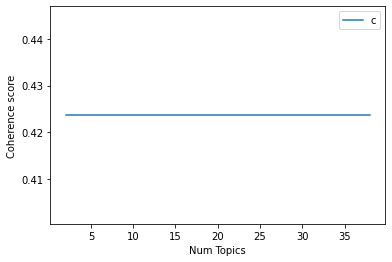

In [28]:
# Show graph to find optimal number of topics
# Coherence value not going flat seems unlikely or probably wrong
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores with increasing number of topics

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2] # when number of topics is 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
# Convert malletmodel to to gensim lda model for pyLDAvis
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis